In [1]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [20]:
SOFT_CONN = True

input_graph = torch.load("data/tree_30.pt")

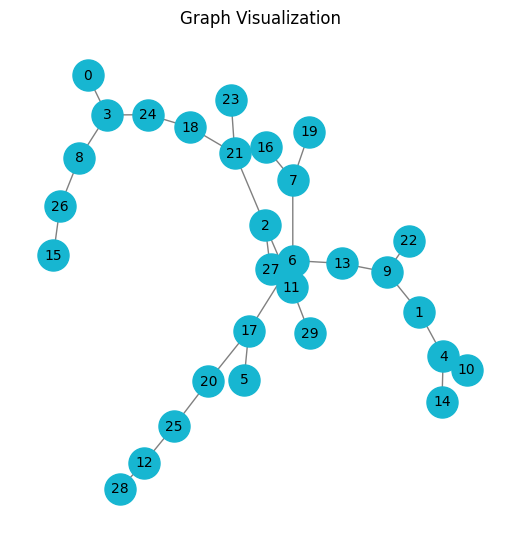

In [23]:
plot_graph(input_graph, labels=True)

In [24]:
alpha = 0.001
niter = 200000
min_change = 0.05
update_steps = 3

niter_sampling = 100000

In [26]:
class MySamplerFiveStats(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)



sampler_five_stats = MySamplerFiveStats(backend="cuda")
obs_five_stats = sampler_five_stats.observables(input_graph)

params_five_stats, _ = sampler_five_stats.param_run(graph=input_graph,
                      observables=obs_five_stats,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [03:12<00:00, 1038.29it/s]

number of accepted steps is:  37242
number of rejected samples:  162758
number of effective updates is:  12414


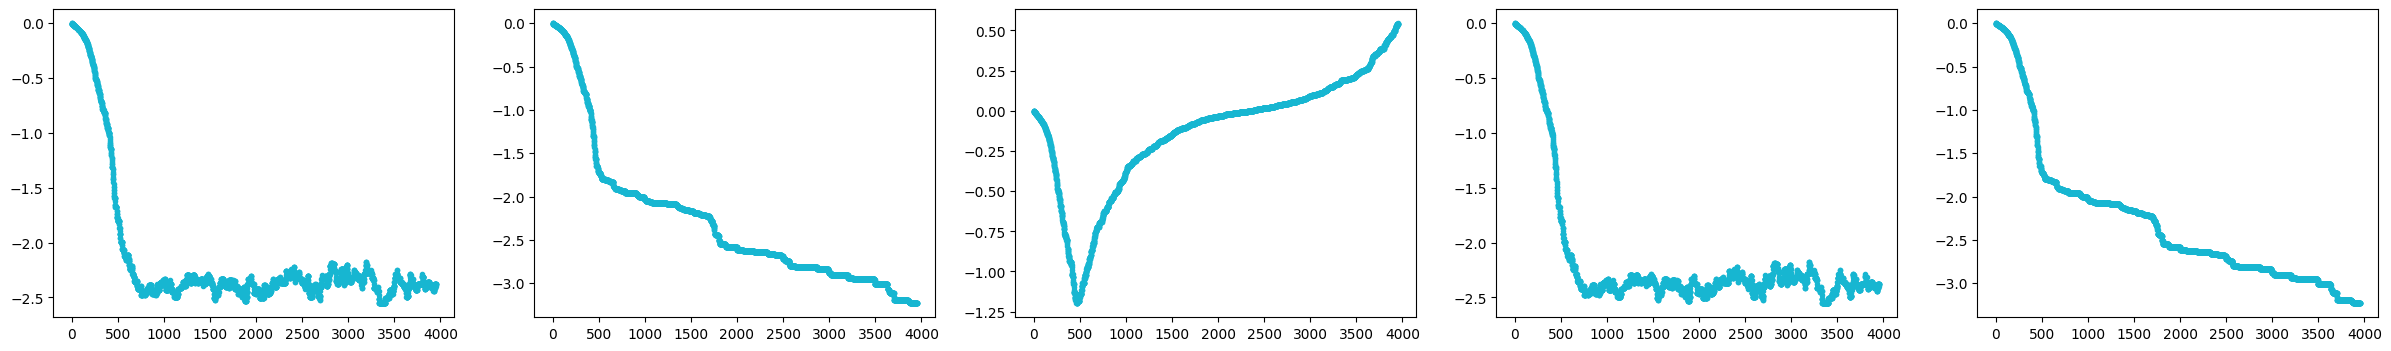

In [27]:
plot_params_iterations(params_five_stats)

In [28]:
params_for_estimates = torch.stack(params_five_stats[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables_five_stats, graphs_five_stats = sampler_five_stats.sample_run(graph=input_graph,
                      observables=obs_five_stats,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 200000/200000 [02:46<00:00, 1203.06it/s]

number of accepted steps is:  26065
number of rejected samples:  173935
Mean obs:  tensor([2.8189e+01, 2.4982e-02, 6.5144e-04, 1.8793e+00, 7.3957e-04],
       dtype=torch.float64)


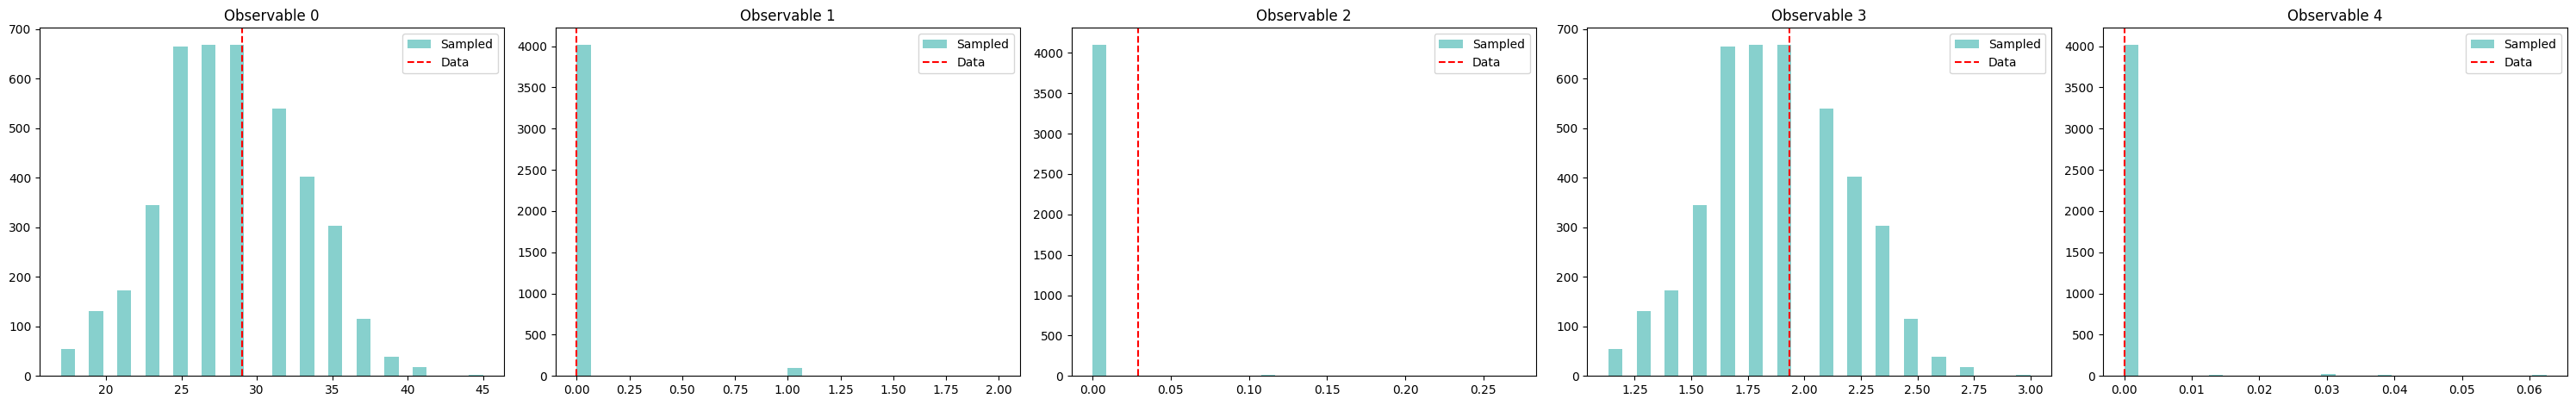

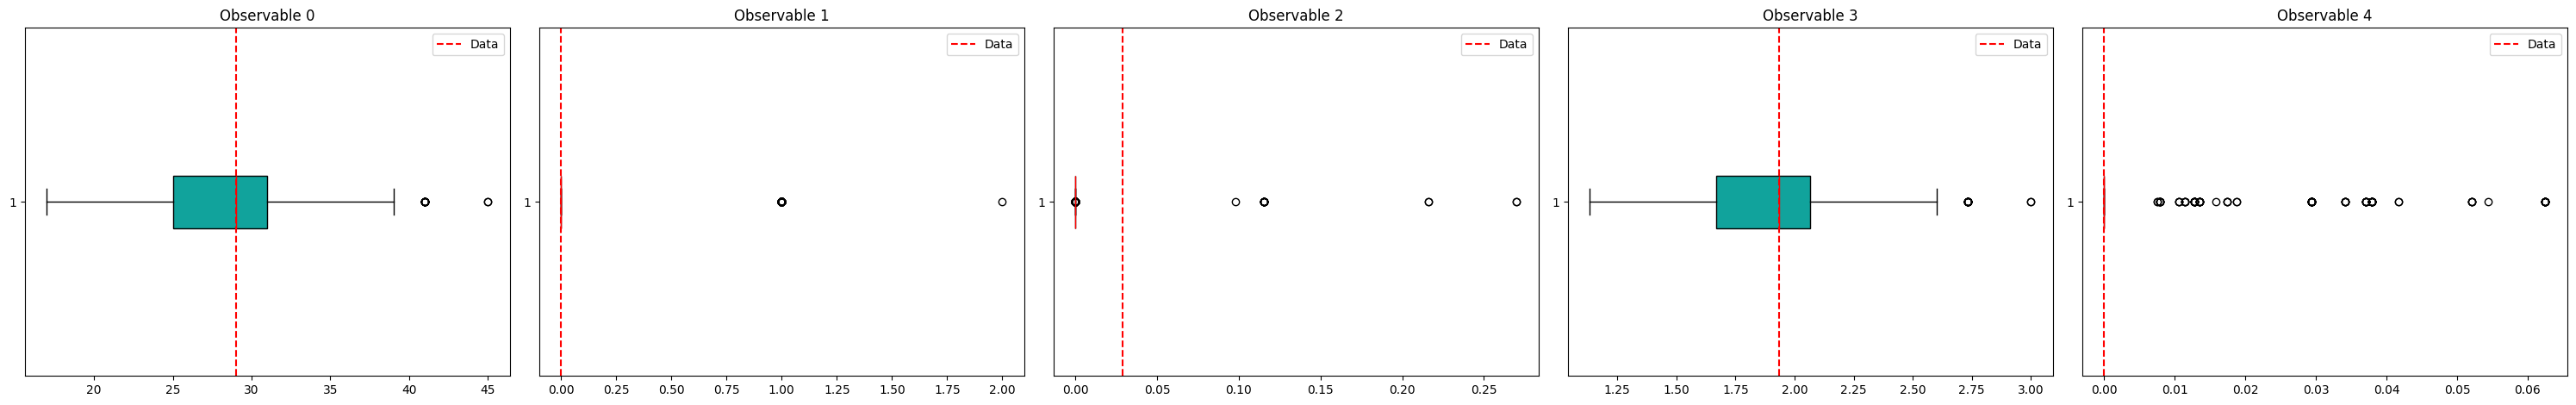

In [30]:
hist_obs_samples(observables_five_stats, obs_five_stats)
boxplot_obs_samples(observables_five_stats, obs_five_stats)

In [31]:
trees_count = 0
for g in graphs_five_stats:
    nx_graph = nx.from_numpy_array(graphs_five_stats[0].numpy())
    connected_components = nx.connected_components(nx_graph)
    maj_graph = nx.subgraph(nx_graph, max(connected_components))

    if nx.is_tree(maj_graph): trees_count+=1

trees_count

0

---

In [41]:
class MyGWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


GWGsampler = MyGWGSampler(backend="cuda")
obsGWG = GWGsampler.observables(input_graph)

paramsGWG, _ = GWGsampler.param_run(graph=input_graph,
                      observables=obsGWG,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [07:37<00:00, 437.57it/s]

number of accepted steps is:  53739
number of rejected samples:  146261
number of effective updates is:  17913


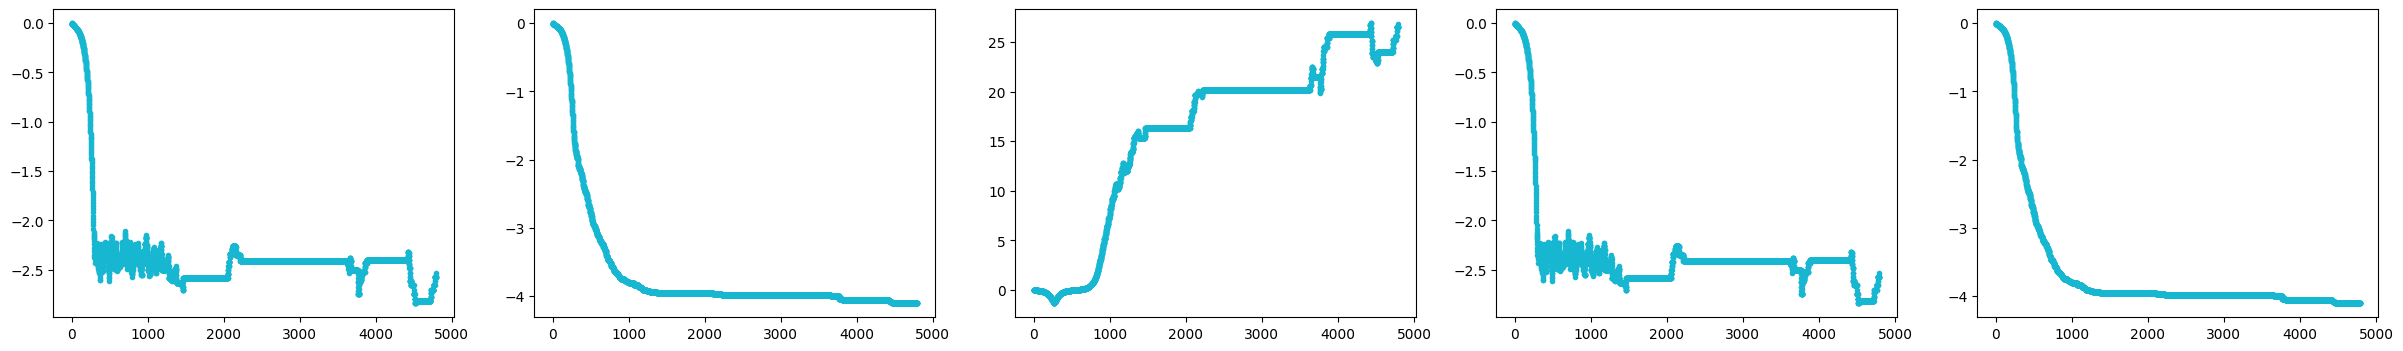

In [42]:
plot_params_iterations(paramsGWG)

In [43]:
params_for_estimates2 = torch.stack(paramsGWG[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observablesGWG, graphsGWG = GWGsampler.sample_run(graph=input_graph,
                      observables=obsGWG,
                      params=params_for_estimates2,
                      niter=100000,
                      save_every=50)

100%|██████████| 100000/100000 [02:39<00:00, 628.28it/s]

number of accepted steps is:  2227
number of rejected samples:  97773
Mean obs:  tensor([2.4356e+01, 1.5601e-03, 7.5898e-03, 1.6237e+00, 2.8890e-05],
       dtype=torch.float64)


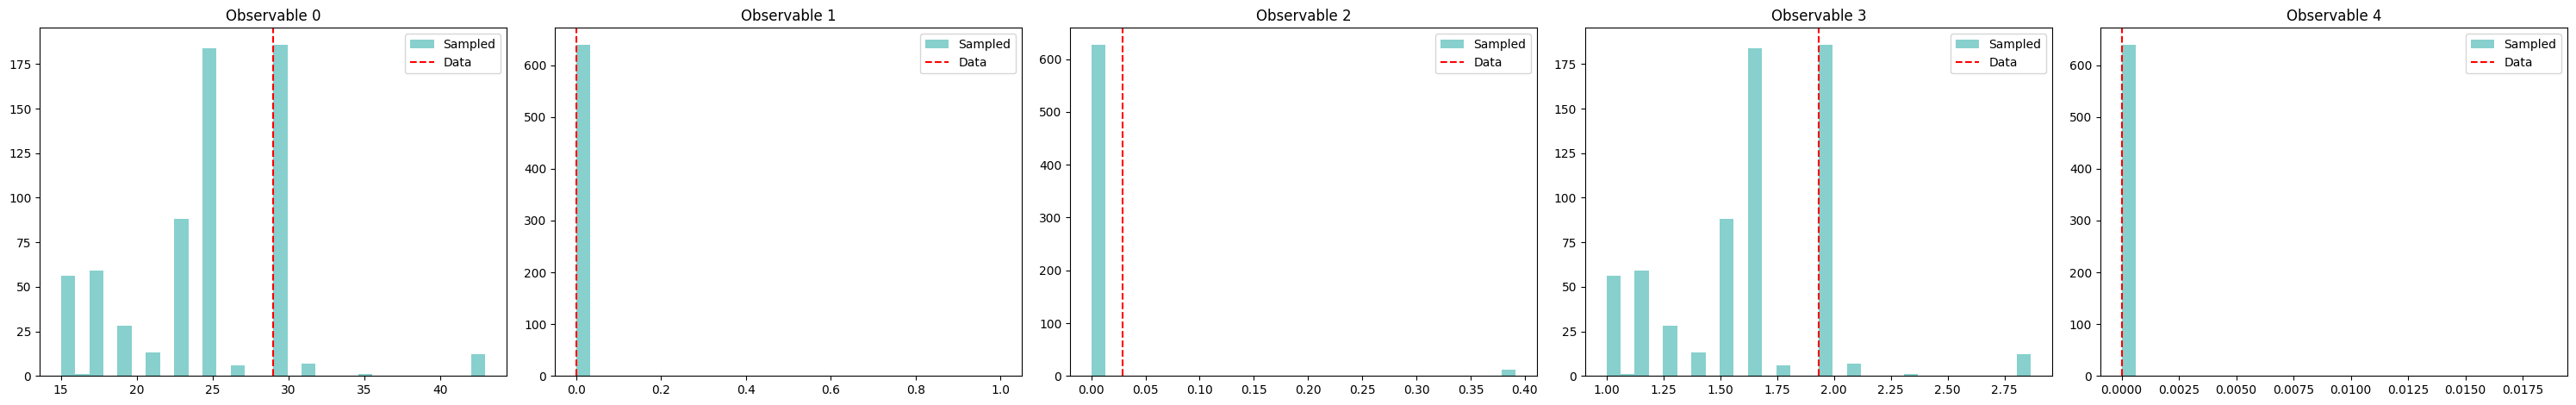

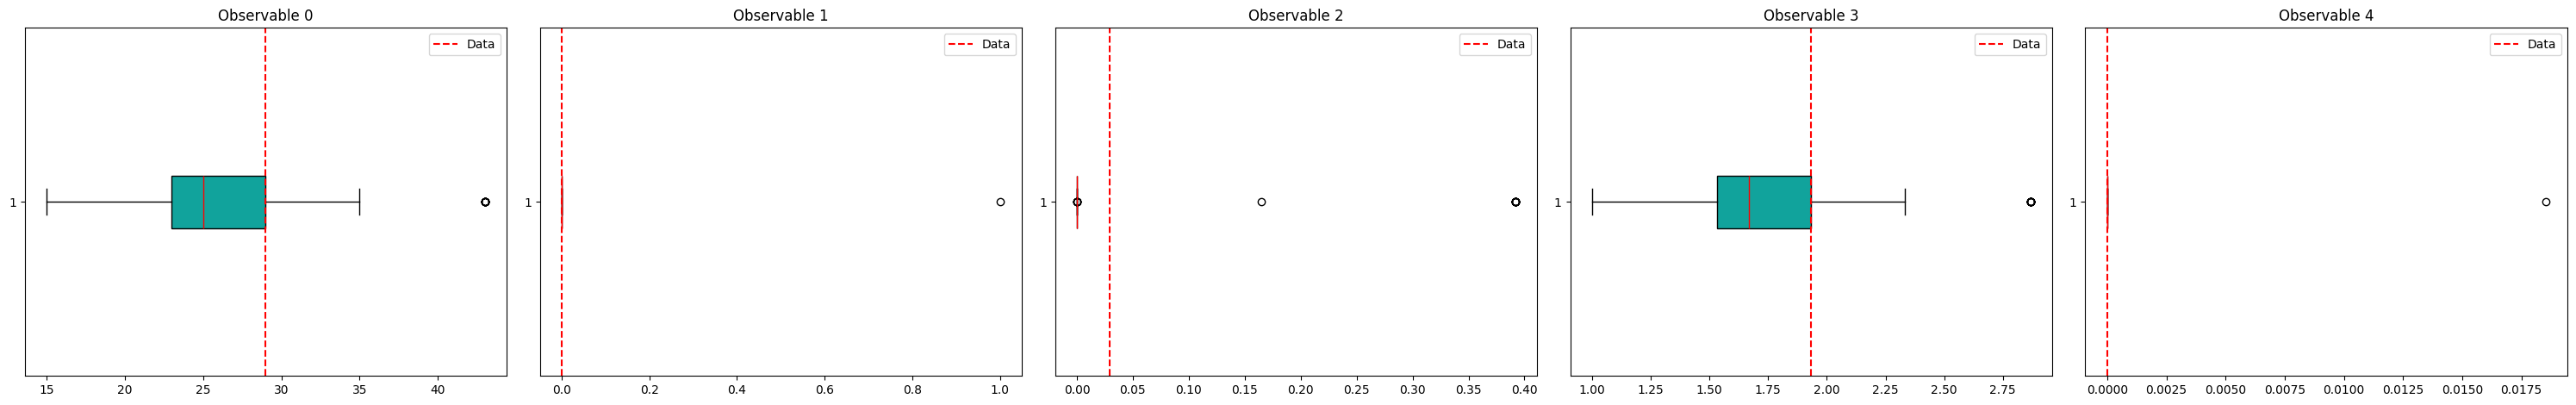

In [44]:
hist_obs_samples(observablesGWG, obsGWG)
boxplot_obs_samples(observablesGWG, obsGWG)

In [45]:
nx_graph = nx.from_numpy_array(graphsGWG[0].numpy())
connected_components = nx.connected_components(nx_graph)
maj_graph = nx.subgraph(nx_graph, max(connected_components))

nx.is_tree(maj_graph)


False

In [46]:
c = 0
for g in graphsGWG:
    nx_graph = nx.from_numpy_array(graphsGWG[0].numpy())
    connected_components = nx.connected_components(nx_graph)
    maj_graph = nx.subgraph(nx_graph, max(connected_components))

    if nx.is_tree(maj_graph): c+=1
        
c

0

In [107]:
print(mean_difference(sampler, input_graph, graphs))
print(mean_difference(GWGsampler, input_graph, graphs2))

tensor([0.1520, 0.0508, 0.0299, 0.0101, 0.0015], dtype=torch.float64)
tensor([0.0000e+00, 0.0000e+00, 6.9389e-18, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64)


In [108]:
params_for_estimates, params_for_estimates2

(tensor([-2.3761e+00, -3.3848e+00,  4.0596e-04, -2.3761e+00, -3.3848e+00],
        dtype=torch.float64),
 tensor([ -2.1367,  -4.7019, 102.5956,  -2.1367,  -4.7019], dtype=torch.float64))

---

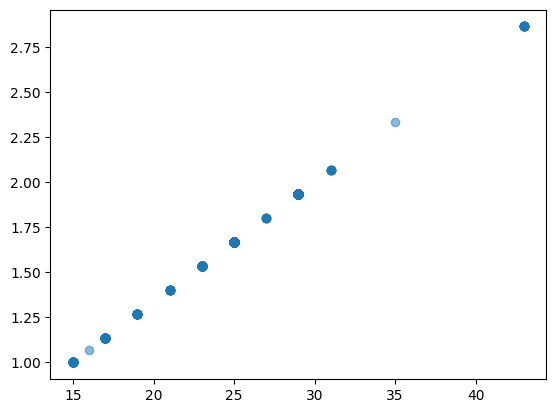

In [56]:
obs_from_sample = torch.stack([o for o in observablesGWG]).numpy()
stat0 = obs_from_sample[:, 0]
stat1 = obs_from_sample[:, 1]
stat2 = obs_from_sample[:, 2]
stat3 = obs_from_sample[:, 3]
stat4 = obs_from_sample[:, 4]

plt.scatter(stat0, stat3, alpha=0.5)